In [13]:
#Ví Dụ 1
# cách 1: Tự xây dựng các bước giải bài toán ràng buộc.
# generate data
# list of points 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)
from matplotlib.backends.backend_pdf import PdfPages

means = [[2, 2], [4, 1]]
cov = [[.5, .2], [.2, .5]]
N = 100
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

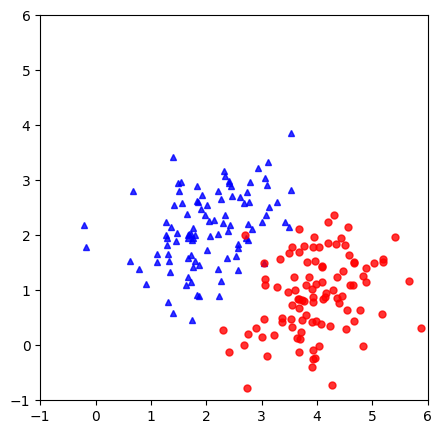

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))  

ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([-1 , 6, -1, 6])
plt.show()

In [15]:
from cvxopt import matrix, solvers
C=200

# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h 
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N))) 
b = matrix(np.zeros((1, 1))) 
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)


lambda = 
 [[5.44024400e-08 1.60248993e-07 1.15680626e+02 6.04097017e-08
  4.56848171e-08 2.79472410e-08 6.95025240e-08 6.40525997e-08
  4.27557887e-08 5.48335204e-08 1.76037860e-07 2.00000000e+02
  5.01490982e-08 3.15135467e-08 3.61403882e-08 2.66327125e-08
  2.00000000e+02 2.76802488e-08 3.15523937e-08 4.32255484e-08
  4.31172279e-08 2.38353668e-08 6.80984429e-08 1.55301487e-07
  3.28354863e-07 3.50315655e-08 3.55787254e-08 3.68517446e-08
  2.77088026e-08 2.48801001e-08 3.33417093e-08 7.10695613e-08
  3.16472377e-08 5.69256798e-08 3.50102098e-08 4.36172744e-08
  1.99999994e+02 1.82789994e-08 1.82433002e-08 6.94218761e-08
  1.41546577e-07 5.06887356e-08 3.26159868e-08 3.08565662e-08
  1.34269920e-07 2.00160223e-07 2.33871401e-08 4.00441212e-08
  1.97171917e-08 2.05683461e-07 8.10364620e-08 4.05136635e-08
  3.35264789e-08 3.62109628e-08 1.58953833e-07 4.53639653e-08
  1.34819547e-07 1.38138332e-07 6.65393734e-08 1.57268560e-07
  3.20913450e-08 5.08992472e-08 1.04314960e-07 6.20507167e-

In [16]:
S = np.where(l > 1e-5)[0] # support set 
S2 = np.where(l < .999*C)[0] 
print(y.shape)
M = [val for val in S if val in S2] # intersection of two lists

XT = X.T # we need each column to be one data point in this alg
VS = V[:, S]
lS = l[S]
yM = y[:,M]
XM = X[:, M]

w_dual = VS.dot(lS).reshape(-1, 1)
w_0_dual = np.mean(yM.T - w_dual.T.dot(XM))
print(w_dual.T, w_0_dual) 
w = w_dual

(1, 200)
[[-3.49214853  2.83441932]] 6.217946644623659


In [17]:
from sklearn.svm import SVC
# Copy and put code for generate data here
y1 = y.reshape((2*N,))
X1 = X.T # each sample is one row
clf = SVC(kernel = 'linear', C = 100) # just a big number 
# if C is small, method will be “SoftMagin SVM”, 
# if C is large enough, method is near to hard margin
clf.fit(X1, y1) 

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('w_0 = ', w0)


w =  [[-3.49143421  2.83300814]]
w_0 =  [6.21730668]


In [18]:
# cách 2
means = [[2, 2], [4, 1]]
cov = [[.5, .2], [.2, .5]]
N = 100
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data 

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + \
        .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias 

def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1] # no weight decay on bias
    return g

eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps 
        wm[i] -= eps 
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g 

w0 = np.random.randn(X0_bar.shape[0], 1) 
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient different: %f' %diff)

Gradient different: 0.000000


In [19]:
def grad_descent(w0, eta):
    w = w0
    it = 0 
    while it < 1000000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-7:
            break 
    return w 
w0 = np.random.randn(X0_bar.shape[0], 1) 
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

iter 1 cost: 236.771456
iter 10001 cost: 15.229142
iter 20001 cost: 15.189826
iter 30001 cost: 15.193203
iter 40001 cost: 15.189807
iter 50001 cost: 15.190172
iter 60001 cost: 15.197053
iter 70001 cost: 15.197417
iter 80001 cost: 15.194717
iter 90001 cost: 15.193799
iter 100001 cost: 15.191909
iter 110001 cost: 15.198789
iter 120001 cost: 15.199155
iter 130001 cost: 15.191335
iter 140001 cost: 15.191478
iter 150001 cost: 15.197770
iter 160001 cost: 15.196851
iter 170001 cost: 15.190614
iter 180001 cost: 15.190979
iter 190001 cost: 15.197860
iter 200001 cost: 15.198225
iter 210001 cost: 15.192816
iter 220001 cost: 15.191898
iter 230001 cost: 15.192716
iter 240001 cost: 15.189319
iter 250001 cost: 15.189684
iter 260001 cost: 15.196565
iter 270001 cost: 15.196930
iter 280001 cost: 15.195869
iter 290001 cost: 15.194950
iter 300001 cost: 15.191421
iter 310001 cost: 15.191786
iter 320001 cost: 15.192151
iter 330001 cost: 15.199032
iter 340001 cost: 15.189273
iter 350001 cost: 15.191632
iter 

In [20]:
#Bài Thực  Hành số 1
# build function to predict
def predict_(w, w0, X):
  return np.sign(np.dot(w.T, X) + w0)

In [21]:
# method 1
w1_1 = np.array([[-3.49216868,  2.83441828]])
w1_0 = 6.218000342653659
y_pred1 = predict_(w1_1.T, w1_0, X)

from sklearn.metrics import accuracy_score, confusion_matrix
print('accuracy:', accuracy_score(y.ravel(), y_pred1.ravel()))
print('confusion_matrix:', confusion_matrix(y.ravel(), y_pred1.ravel()))

accuracy: 0.965
confusion_matrix: [[94  6]
 [ 1 99]]


In [22]:
# method 2
w2_1 = np.array([[-3.49143421,  2.83300814]])
w2_0 = [6.21730668]
y_pred2 = predict_(w2_1.T, w2_0, X)

from sklearn.metrics import accuracy_score, confusion_matrix
print('accuracy:', accuracy_score(y.ravel(), y_pred2.ravel()))
print('confusion_matrix:', confusion_matrix(y.ravel(), y_pred2.ravel()))

accuracy: 0.965
confusion_matrix: [[94  6]
 [ 1 99]]


In [23]:
# method 3
w3_1 = np.array([[-3.8281209,   1.97956923]])
w3_0 = [8.56016034]
y_pred3 = predict_(w3_1.T, w3_0, X)

from sklearn.metrics import accuracy_score, confusion_matrix
print('accuracy:', accuracy_score(y.ravel(), y_pred3.ravel()))
print('confusion_matrix:', confusion_matrix(y.ravel(), y_pred3.ravel()))

accuracy: 0.965
confusion_matrix: [[ 93   7]
 [  0 100]]


In [24]:
#Bài tập thực hành số 2
from sklearn import datasets
cancer_data = datasets.load_breast_cancer()

# show to test record 5th
print(cancer_data.data[5])

print(cancer_data.data.shape)
# target set
print(cancer_data.target)

from sklearn.model_selection import train_test_split

cancer_data = datasets.load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer_data.data, 
                                                    cancer_data.target,
                                                    test_size = 0.3,
                                                    random_state=42)

[1.245e+01 1.570e+01 8.257e+01 4.771e+02 1.278e-01 1.700e-01 1.578e-01
 8.089e-02 2.087e-01 7.613e-02 3.345e-01 8.902e-01 2.217e+00 2.719e+01
 7.510e-03 3.345e-02 3.672e-02 1.137e-02 2.165e-02 5.082e-03 1.547e+01
 2.375e+01 1.034e+02 7.416e+02 1.791e-01 5.249e-01 5.355e-01 1.741e-01
 3.985e-01 1.244e-01]
(569, 30)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 

In [25]:
from sklearn.svm import SVC
clf = SVC(kernel = 'linear', C = 100)
clf.fit(X_train, y_train)

SVC(C=100, kernel='linear')

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('confusion_matrix:', confusion_matrix(y_test, y_pred))

accuracy: 0.9473684210526315
confusion_matrix: [[ 59   4]
 [  5 103]]


In [27]:
#Bài tập tự giải
import pandas as pd

df = pd.read_csv('sonar.all-data.csv', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [28]:
df[60] = df[60].replace({'R': -1, 'M': 1})
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,-1
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,-1
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,-1
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,-1
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,-1


In [29]:
Data = df.drop(columns = [60], axis = 1)
labels = df[60]

In [30]:
print(Data.shape)
print(labels.shape)

(208, 60)
(208,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size = 0.3, random_state=42)

In [32]:
clf = SVC(kernel = 'linear', C = 100)
clf.fit(X_train, y_train)

SVC(C=100, kernel='linear')

In [33]:
y_pred = clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('confusion_matrix:', confusion_matrix(y_test, y_pred))

accuracy: 0.7142857142857143
confusion_matrix: [[20  8]
 [10 25]]


In [34]:
#Ví dụ 3
import gzip

In [35]:
!unzip spambase.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [36]:
df = pd.read_csv('spambase.data', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [37]:
df[57].unique()

array([1, 0], dtype=int64)

In [38]:
df[57] = df[57].replace({0 : -1})

In [39]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
4596,0.31,0.0,0.62,0.0,0.00,0.31,0.0,0.0,0.0,0.0,...,0.000,0.232,0.0,0.000,0.0,0.0,1.142,3,88,-1
4597,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.353,0.0,0.0,1.555,4,14,-1
4598,0.30,0.0,0.30,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.102,0.718,0.0,0.000,0.0,0.0,1.404,6,118,-1
4599,0.96,0.0,0.00,0.0,0.32,0.00,0.0,0.0,0.0,0.0,...,0.000,0.057,0.0,0.000,0.0,0.0,1.147,5,78,-1
4600,0.00,0.0,0.65,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0.125,0.0,0.0,1.250,5,40,-1


In [40]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range= (0, 1))
Data = sc.fit_transform(df.drop(columns =[57], axis = 1))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(Data, df[57], test_size=0.3, random_state=42)

In [42]:
X_train.shape, y_train.shape

((3220, 57), (3220,))

In [43]:
clf = SVC(kernel = 'linear', C=100)
clf.fit(X_train, y_train)

SVC(C=100, kernel='linear')

In [44]:
y_pred = clf.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('confusion_matrix:', confusion_matrix(y_test, y_pred))

accuracy: 0.9254163649529327
confusion_matrix: [[765  39]
 [ 64 513]]
